电商平台零售数据分析

提出问题
●项目背景
●此次项目数据来自Kaggle,包含了2010年12月1日至2011年12月9日在英国注册的非实体网上零
售发生的所有交易。公司主要销售独特的全天候礼品。该公司的许多客户都是批发商。
分析目的
●用户分类(RFM模型) ,对比分析不同用户群体在时间、地区等维度下交易量,交易金额指
标，并根据分析结果提出优化建议。

In [27]:
# 忽略警告提示
import warnings
warnings.filterwarnings('ignore')
# 导入处理数据包
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import plotly.graph_objs as go

# os.chdir(r'C:\Users\Administrator\Desktop')
os.chdir('./')


In [ ]:
!ls

In [ ]:
#导入可视化库
import plotly as py

py.offline.init_notebook_mode()#初始化步骤
pyplot = py.offline.iplot #画图函数


In [ ]:
#读取数据
df  = pd.read_csv('data.csv',encoding='ISO-8859-1',dtype={'CustomerID':str})

In [ ]:
df.shape

In [ ]:
df.head()
# df.tail()  # 不能同时打出来的吗？

In [ ]:
df.info()

●字段解释:
InvoiceNo-->订单号码: 6位字符串
StockCode -->产品代码: 6位字符串
Description-->产品描述
Quantity-->产品数量:交易产品数量
InvoiceDate-->订单日期:订单发生的日期和时间
UnitPrice-->单价:浮点数值
CustomerID -->顾客ID: 5位字符串
Country-->国家:客户所在地

In [ ]:
#统计缺失率
df.apply(lambda x: sum(x.isnull())/len(x), axis=0)

In [ ]:
# Description字段对于分析结果影响不大，选择直接删除改变量
df.drop(['Description'],axis=1,inplace=True)  # inplace：就地
# CustomerID字段为客户编号，不能直接删除，选择填充为U (表示未知)
df['CustomerID'] = df['CustomerID'].fillna('U')

In [ ]:
df.info()

In [ ]:
df.head(10)

●为方便后续分析，将订单日期拆分，增加年 月 日 时间四个字段；增加合计购买字段;

In [ ]:
#增加合计购买金额 (amount) =数量*金额
df['amount']= df['Quantity']*df['UnitPrice']
#订单日期切分
df['date']=[x.split(' ')[0] for x in df['InvoiceDate']]
df['time']=[x.split(' ')[1] for x in df['InvoiceDate']]

df.drop(['InvoiceDate'],axis=1,inplace=True)  # 删除原有的字符串的日期时间列

df['year']=[x.split('/')[2] for x in df['date']]
df['month']=[x.split('/')[0] for x in df['date']]
df['day']=[x.split('/')[1] for x in df['date']]

#转换日期格式
df['date'] = pd.to_datetime(df['date'])
print(df.shape)
df.head()

In [ ]:
df.dtypes

In [ ]:
#重复值处理，删除重复行,重复的是系统错误，或人工操作出错
df = df.drop_duplicates()
df.shape

In [ ]:
#异常的处理
#通过观察平均值和中值的差异来判断是否有异常数据
df.describe()

In [ ]:
df.loc[df['Quantity'] <= 0]

In [ ]:
#查看数据发现商品数量和单价存在负值。进一步查看异常数据。不能为负值的特征，有负值的去掉
#商品数量异常，其实就是退货
df1 = df.loc[df['Quantity'] <= 0]
print('异常数据比例:',df1.shape[0]/df.shape[0])

In [ ]:
df.loc[df['UnitPrice'] < 0]  #肯定是异常值

In [ ]:
#单价小于零的也是异常值，单价为0可以认为是赠品
df2 = df.loc[df['UnitPrice'] <= 0]
print('异常数据比例:',df2.shape[0]/df.shape[0])

In [ ]:
df2['UnitPrice'].head(10)

In [ ]:
#查看数据发现单价为零居多，查看单价分类
#单价为负是有问题的，是系统异常
#为零也是异常，我们这里是看单价异常的分类
df2['UnitPrice'].groupby(df2['UnitPrice']).count()

●查询单价异常结果一共2512条,其中2510条为单价为0,预计为促销赠品;还有2条单价负数明细为坏账记录。本次不做分析

## 四、数据分析

1.退货订单分析

In [23]:
df1.head()

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,Country,amount,date,time,year,month,day
141,C536379,D,-1,27.50,14527,United Kingdom,-27.50,2010-12-01,9:41,2010,12,1
154,C536383,35004C,-1,4.65,15311,United Kingdom,-4.65,2010-12-01,9:49,2010,12,1
235,C536391,22556,-12,1.65,17548,United Kingdom,-19.80,2010-12-01,10:24,2010,12,1
236,C536391,21984,-24,0.29,17548,United Kingdom,-6.96,2010-12-01,10:24,2010,12,1
237,C536391,21983,-24,0.29,17548,United Kingdom,-6.96,2010-12-01,10:24,2010,12,1


In [24]:
df1.tail()

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,Country,amount,date,time,year,month,day
540449,C581490,23144,-11,0.83,14397,United Kingdom,-9.13,2011-12-09,9:57,2011,12,9
541541,C581499,M,-1,224.69,15498,United Kingdom,-224.69,2011-12-09,10:28,2011,12,9
541715,C581568,21258,-5,10.95,15311,United Kingdom,-54.75,2011-12-09,11:57,2011,12,9
541716,C581569,84978,-1,1.25,17315,United Kingdom,-1.25,2011-12-09,11:58,2011,12,9
541717,C581569,20979,-5,1.25,17315,United Kingdom,-6.25,2011-12-09,11:58,2011,12,9


In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10587 entries, 141 to 541717
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   InvoiceNo   10587 non-null  object        
 1   StockCode   10587 non-null  object        
 2   Quantity    10587 non-null  int64         
 3   UnitPrice   10587 non-null  float64       
 4   CustomerID  10587 non-null  object        
 5   Country     10587 non-null  object        
 6   amount      10587 non-null  float64       
 7   date        10587 non-null  datetime64[ns]
 8   time        10587 non-null  object        
 9   year        10587 non-null  object        
 10  month       10587 non-null  object        
 11  day         10587 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 1.1+ MB


In [33]:
#退货的超级透视
#退货合计金额
#margins=True 会给一个All的汇总
print(df1)
tt=pd.pivot_table(df1,index=['year'],columns=['month'], values=['amount'],aggfunc={'amount':np.sum},margins=False)
sale_no=tt.iloc[0:2]
sale_no.fillna(0)  # 展示的是这个

       InvoiceNo StockCode  Quantity  UnitPrice CustomerID         Country  \
141      C536379         D        -1      27.50      14527  United Kingdom   
154      C536383    35004C        -1       4.65      15311  United Kingdom   
235      C536391     22556       -12       1.65      17548  United Kingdom   
236      C536391     21984       -24       0.29      17548  United Kingdom   
237      C536391     21983       -24       0.29      17548  United Kingdom   
...          ...       ...       ...        ...        ...             ...   
540449   C581490     23144       -11       0.83      14397  United Kingdom   
541541   C581499         M        -1     224.69      15498  United Kingdom   
541715   C581568     21258        -5      10.95      15311  United Kingdom   
541716   C581569     84978        -1       1.25      17315  United Kingdom   
541717   C581569     20979        -5       1.25      17315  United Kingdom   

        amount       date   time  year month day  
141     -27.

amount                                                              \
month          1       10        11         12         2         3         4   
year                                                                           
2010        0.00      0.0      0.00  -74729.12      0.00      0.00      0.00   
2011  -131363.05 -81895.5 -47720.98 -205089.27 -25519.15 -34201.28 -44600.65   

                                                        
month         5         6         7        8         9  
year                                                    
2010       0.00      0.00      0.00      0.0      0.00  
2011  -47202.51 -70569.78 -37919.13 -54330.8 -38838.51

In [34]:
#合计金额,margins代表是否做汇总，是否有all
df2 = df[(df['Quantity'] > 0)&(df['UnitPrice'] > 0)]
pp = pd.pivot_table(df2,index=['year'],columns=['month'],values=['amount'],aggfunc={'amount':np.sum},margins=False)
sale = pp.iloc[0:2]
sale.fillna(0)

amount                                                           \
month          1          10          11         12          2          3   
year                                                                        
2010        0.00        0.00        0.00  821452.73       0.00       0.00   
2011   689811.61  1151263.73  1503329.78  637790.33  522545.56  716215.26   

                                                                             
month           4          5          6           7          8            9  
year                                                                         
2010        0.000       0.00       0.00       0.000       0.00        0.000  
2011   536968.491  769281.76  760547.01  718076.121  757841.38  1056435.192

In [36]:
print(df2['InvoiceNo']=='536379')
df2[df2['InvoiceNo']=='536379']  #退货订单编号和原有订单编号无关系，通过把C去掉来分析

0         False
1         False
2         False
3         False
4         False
          ...  
541904    False
541905    False
541906    False
541907    False
541908    False
Name: InvoiceNo, Length: 524876, dtype: bool


,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,Country,amount,date,time,year,month,day


In [38]:
#看一个跟退货相关的用户ID，发现退货的用户，并没有在购买的用户的里边?
df2[df2['CustomerID']=='14397']

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,Country,amount,date,time,year,month,day
182820,552575,22178,24,1.25,14397,United Kingdom,30.00,2011-05-10,12:25,2011,5,10
182821,552575,23144,12,0.83,14397,United Kingdom,9.96,2011-05-10,12:25,2011,5,10
182822,552575,20846,12,1.25,14397,United Kingdom,15.00,2011-05-10,12:25,2011,5,10
182823,552575,82484,2,7.95,14397,United Kingdom,15.90,2011-05-10,12:25,2011,5,10
182824,552575,84946,12,1.25,14397,United Kingdom,15.00,2011-05-10,12:25,2011,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...
533099,581011,23144,48,0.83,14397,United Kingdom,39.84,2011-12-07,9:22,2011,12,7
533100,581011,23145,24,0.95,14397,United Kingdom,22.80,2011-12-07,9:22,2011,12,7
533101,581011,22478,20,1.25,14397,United Kingdom,25.00,2011-12-07,9:22,2011,12,7
533102,581011,20846,24,1.25,14397,United Kingdom,30.00,2011-12-07,9:22,2011,12,7


In [39]:
df2.count()

InvoiceNo     524876
StockCode     524876
Quantity      524876
UnitPrice     524876
CustomerID    524876
Country       524876
amount        524876
date          524876
time          524876
year          524876
month         524876
day           524876
dtype: int64

In [41]:
#退货率
rate = tt/pp
print(rate)
print(rate.index)
print("*"*50)
rate.columns

         amount                                                             \
month         1        10        11        12         2         3        4   
year                                                                         
2010        NaN       NaN       NaN -0.090972       NaN       NaN      NaN   
2011  -0.190433 -0.071135 -0.031744 -0.321562 -0.048836 -0.047753 -0.08306   

                                                         
month         5         6         7         8         9  
year                                                     
2010        NaN       NaN       NaN       NaN       NaN  
2011  -0.061359 -0.092788 -0.052807 -0.071692 -0.036764  
Index(['2010', '2011'], dtype='object', name='year')
**************************************************


MultiIndex([('amount',  '1'),
            ('amount', '10'),
            ('amount', '11'),
            ('amount', '12'),
            ('amount',  '2'),
            ('amount',  '3'),
            ('amount',  '4'),
            ('amount',  '5'),
            ('amount',  '6'),
            ('amount',  '7'),
            ('amount',  '8'),
            ('amount',  '9')],
           names=[None, 'month'])

In [42]:
#因为2010年只有一个月，所以不管
print(np.abs(rate).loc['2011'].mean())
rate

0.09249438130255956


amount                                                             \
month         1        10        11        12         2         3        4   
year                                                                         
2010        NaN       NaN       NaN -0.090972       NaN       NaN      NaN   
2011  -0.190433 -0.071135 -0.031744 -0.321562 -0.048836 -0.047753 -0.08306   

                                                         
month         5         6         7         8         9  
year                                                     
2010        NaN       NaN       NaN       NaN       NaN  
2011  -0.061359 -0.092788 -0.052807 -0.071692 -0.036764

●可以看到，退货率最高为2011年1月和12月，试将结果可视化

●2011年1月和12月退货率均高于平均退货率9%。特别是2011年12月，
具体情况成与相关部门沟通是什么原因导致，并且分析前几年的退货
率，是否存在同样的问题。因为可能是圣诞节购物较多

# 2、用户分类

RFM模型是衡星客户价值和客户创利能力的重要工具和手段。通过一个客户的近期购买行为、购买的总体频率以及花了多少钱三项指标来描该客户的价值状况。
●R:最近一次消费时间(最近一次消费到参考时间的间隔)
●F:消费的频次(消费了多少次)
●M:消费的金额(总消费金额)

In [ ]:
df2.info()

In [47]:
#客户最近一次消费时间,直接找日期的最大值即可,把df2['date'].max()日期中最大的作为参照
R_value=df2.groupby('CustomerID')['date'].max()
print(R_value)
print(df2['date'].max())
#计算客户最后一次消费距离截止日期的天数,越大越好，还是越小越好？
print('-'*50)
print(df2['date'].max()- R_value)
print('-'*50)
R = (df2['date'].max()- R_value).dt.days  #拿到时间值，整型数，方便运算
print(R)
#客户消费频率，nunique是去重后计算个数
print('-'*50)
F = df2.groupby('CustomerID')['InvoiceNo'].nunique()  #得到了消费频次：一个订单编号算一次消费行为
#客户消费金额
M = df2.groupby('CustomerID')['amount'].sum()
print(F)
print(M)

CustomerID
12346   2011-01-18
12347   2011-12-07
12348   2011-09-25
12349   2011-11-21
12350   2011-02-02
           ...    
18281   2011-06-12
18282   2011-12-02
18283   2011-12-06
18287   2011-10-28
U       2011-12-09
Name: date, Length: 4339, dtype: datetime64[ns]
2011-12-09 00:00:00
--------------------------------------------------
CustomerID
12346   325 days
12347     2 days
12348    75 days
12349    18 days
12350   310 days
          ...   
18281   180 days
18282     7 days
18283     3 days
18287    42 days
U         0 days
Name: date, Length: 4339, dtype: timedelta64[ns]
--------------------------------------------------
CustomerID
12346    325
12347      2
12348     75
12349     18
12350    310
        ... 
18281    180
18282      7
18283      3
18287     42
U          0
Name: date, Length: 4339, dtype: int64
--------------------------------------------------
CustomerID
12346       1
12347       7
12348       4
12349       1
12350       1
         ... 
18281       1
18282     

●分别查看R/F/M值，对其设置合理阈值，进行分层

In [48]:
R.describe()

count    4339.000000
mean       92.038258
std       100.010502
min         0.000000
25%        17.000000
50%        50.000000
75%       141.500000
max       373.000000
Name: date, dtype: float64

In [49]:
F.describe()

count    4339.000000
mean        4.600138
std        22.943499
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      1428.000000
Name: InvoiceNo, dtype: float64

In [50]:
M.describe()

count    4.339000e+03
mean     2.452537e+03
std      2.808589e+04
min      3.750000e+00
25%      3.065050e+02
50%      6.685800e+02
75%      1.660890e+03
max      1.754902e+06
Name: amount, dtype: float64

In [51]:
R.max()

373

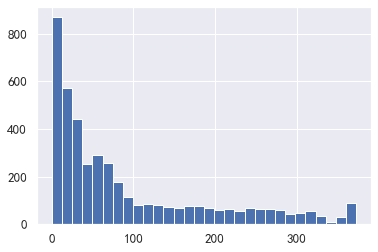

In [52]:
import seaborn as sns
sns.set(style='darkgrid',context='notebook',font_scale=1.2)# 设置背景
# 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.hist(R,bins =30)
plt.show()

●可以看到，截止2011年12月9日，最后一次消费距离截止日期的天数平均为92天，标准差为100,波动较大。距离天数最大超过一年。

In [53]:
print(F)
#查看F值
F.describe()

CustomerID
12346       1
12347       7
12348       4
12349       1
12350       1
         ... 
18281       1
18282       2
18283      16
18287       3
U        1428
Name: InvoiceNo, Length: 4339, dtype: int64


count    4339.000000
mean        4.600138
std        22.943499
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      1428.000000
Name: InvoiceNo, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

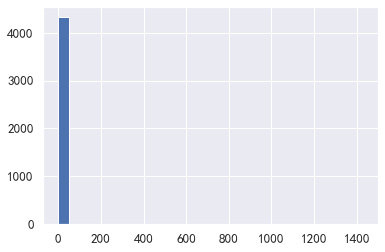

In [54]:
plt.hist(F,bins =30)
plt.show

In [55]:
F[F<30].count()/F.count()

0.9891680110624568

In [56]:
F[F==7]

CustomerID
12347    7
12433    7
12457    7
12472    7
12494    7
        ..
17937    7
17988    7
18094    7
18230    7
18245    7
Name: InvoiceNo, Length: 143, dtype: int64

●由于极值的影响，可视化不明显。

<function matplotlib.pyplot.show(close=None, block=None)>

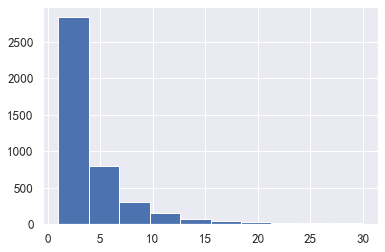

In [57]:
#查看频次小于50的
plt.hist(F[F<=30],bins =10)
plt.show

In [58]:
#查看M值
M.describe()

count    4.339000e+03
mean     2.452537e+03
std      2.808589e+04
min      3.750000e+00
25%      3.065050e+02
50%      6.685800e+02
75%      1.660890e+03
max      1.754902e+06
Name: amount, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

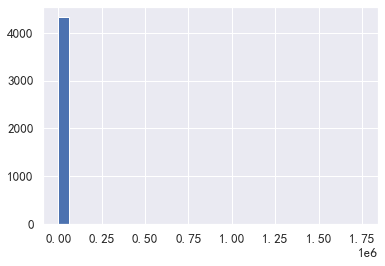

In [59]:
plt.hist(M,bins =30)
plt.show

In [ ]:
# 查看金额小于2000的分布

In [60]:
M[M<3000].count()/M.count()

0.8720903433970961

<function matplotlib.pyplot.show(close=None, block=None)>

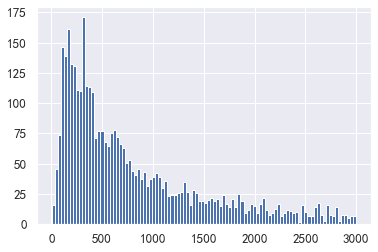

In [61]:
plt.hist(M[M<3000],bins=100)
plt.show

# 针对之前的分析，对用户进行分级

In [62]:
s = pd.Series(np.array([1, 3, 6, 8, 9]),
              index=['a', 'b', 'c', 'd', 'e'])

In [63]:
s

a    1
b    3
c    6
d    8
e    9
dtype: int32

In [67]:
#左闭右开
pd.cut(s, [0, 2, 4, 6, 8, 10], labels=[5,4,3,2,1], retbins=True, right=False)

(a    5
 b    4
 c    2
 d    1
 e    1
 dtype: category
 Categories (5, int64): [5 < 4 < 3 < 2 < 1],
 array([ 0,  2,  4,  6,  8, 10]))

In [68]:
R_bins = [0,30,90,180,360,720]  #越小越好，刚来消费过的用户价值较高
F_bins = [1,2,5,10,20,500]  #越大越好
M_bins = [0,500,2000,5000,10000,200000] #越大越好

In [69]:
#数据离散化
R_score = pd.cut(R,R_bins, labels = [5,4,3,2,1], right=False)
F_score = pd.cut(F,F_bins, labels = [1,2,3,4,5], right=False)
M_score = pd.cut(M,M_bins, labels = [1,2,3,4,5], right=False)
print(R_score)
print(F_score)
print(M_score)

CustomerID
12346    2
12347    5
12348    4
12349    5
12350    2
        ..
18281    2
18282    5
18283    5
18287    4
U        5
Name: date, Length: 4339, dtype: category
Categories (5, int64): [5 < 4 < 3 < 2 < 1]
CustomerID
12346      1
12347      3
12348      2
12349      1
12350      1
        ... 
18281      1
18282      2
18283      4
18287      2
U        NaN
Name: InvoiceNo, Length: 4339, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]
CustomerID
12346      5
12347      3
12348      2
12349      2
12350      1
        ... 
18281      1
18282      1
18283      3
18287      2
U        NaN
Name: amount, Length: 4339, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


In [70]:
rfm = pd.concat([R_score,F_score,M_score],axis=1) #数据合并
print(rfm)

           date InvoiceNo amount
CustomerID                      
12346         2         1      5
12347         5         3      3
12348         4         2      2
12349         5         1      2
12350         2         1      1
...         ...       ...    ...
18281         2         1      1
18282         5         2      1
18283         5         4      3
18287         4         2      2
U             5       NaN    NaN

[4339 rows x 3 columns]


In [71]:
#通过rename接口，用字典去修改columns索引
rfm.rename(columns={'date':'R_score','InvoiceNo':'F_score','amount':'M_score'},inplace = True)

In [72]:
rfm.head(n=50)

,R_score,F_score,M_score
CustomerID,,,
12346,2,1,5
12347,5,3,3
12348,4,2,2
12349,5,1,2
12350,2,1,1
12352,4,3,3
12353,2,1,1
12354,2,1,2
12355,2,1,1


In [73]:
rfm.dtypes

R_score    category
F_score    category
M_score    category
dtype: object

In [74]:
#数据类型转换
for i in ['R_score','F_score','M_score']:
    rfm[i] = rfm[i].astype(float)

In [75]:
#和上面等价
rfm=rfm.astype(float)

In [76]:
rfm.dtypes

R_score    float64
F_score    float64
M_score    float64
dtype: object

In [ ]:
rfm.describe()

In [77]:
rfm['R'] = np.where(rfm['R_score']>3.82,'高','低')

In [78]:
rfm['F'] = np.where(rfm['F_score']>2.03,'高','低')

In [79]:
rfm['M'] = np.where(rfm['M_score']>1.89,'高','低')

In [80]:
rfm.head()

,R_score,F_score,M_score,R,F,M
CustomerID,,,,,,
12346,2.0,1.0,5.0,低,低,高
12347,5.0,3.0,3.0,高,高,高
12348,4.0,2.0,2.0,高,低,高
12349,5.0,1.0,2.0,高,低,高
12350,2.0,1.0,1.0,低,低,低


In [81]:
rfm['value'] = rfm['R'].str[:] + rfm['F'].str[:]+rfm['M'].str[:] #字符串拼接

In [82]:
rfm['value'] = rfm['value'].str.strip()#去除字符串空格

In [83]:
rfm

,R_score,F_score,M_score,R,F,M,value
CustomerID,,,,,,,
12346,2.0,1.0,5.0,低,低,高,低低高
12347,5.0,3.0,3.0,高,高,高,高高高
12348,4.0,2.0,2.0,高,低,高,高低高
12349,5.0,1.0,2.0,高,低,高,高低高
12350,2.0,1.0,1.0,低,低,低,低低低
...,...,...,...,...,...,...,...
18281,2.0,1.0,1.0,低,低,低,低低低
18282,5.0,2.0,1.0,高,低,低,高低低
18283,5.0,4.0,3.0,高,高,高,高高高


In [84]:
def trans_value(x):
    if x=='高高高':
        return '重要价值客户'
    elif x =='高低高':
        return '重要发展客户'
    elif x =='低高高':
        return '重要保持客户'
    elif x =='低低高':
        return '重要挽留客户'
    elif x == '高高低':
        return '一般价值客户'
    elif x =='高低低':
        return '一般发展客户'
    elif x =='低高低':
        return '一般保持客户'
    else:
        return '一般挽留客户'

In [85]:
rfm['用户等级'] = rfm['value'].apply( trans_value)

In [86]:
rfm['用户等级'].value_counts()

重要价值客户    1034
重要发展客户    1017
一般挽留客户     923
一般发展客户     830
重要挽留客户     455
重要保持客户      66
一般价值客户       9
一般保持客户       5
Name: 用户等级, dtype: int64

In [87]:
#对结果可视化
trace_basic = [go.Bar(x =rfm['用户等级'].value_counts().index.tolist(),
                      y =rfm['用户等级'].value_counts().values.tolist(),
                      marker=dict(color='orange'),opacity=0.50)] #透明度
layout = go.Layout(title = '用户等级情况',xaxis =dict(title ='用户重要度'))
figure_basic = go.Figure(data = trace_basic,layout=layout)# data与layout组成一个图象对象
pyplot(figure_basic) #输出

In [88]:
trace = [go.Pie(labels = rfm['用户等级'].value_counts().index,values=rfm['用户等级'].value_counts().values,hole=0.2,
                textfont =dict(size=12,color ='white'))]
layout = go.Layout(title ='用户等级比例')
fig = go.Figure(data = trace,layout=layout) # data与layout组成一 个图象对象
pyplot(fig) #输出

# 五 结论和建议